✅ Loaded AnnData: 800 cells × 36753 genes
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
computing UMAP
    finished (0:00:00)
✅ Results saved to /home/jovyan/work/Results/script3/scanpy_clusters_umap.csv
✅ AnnData salvato in /home/jovyan/work/Results/script3/adata_script3.h5ad


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


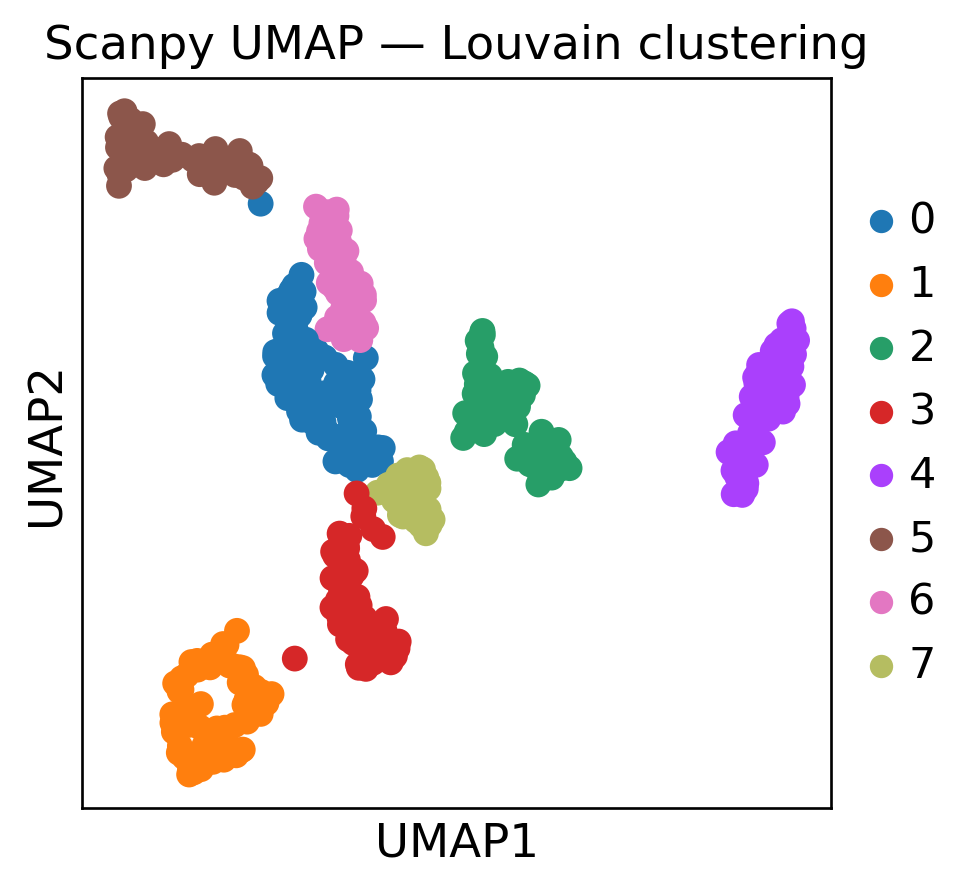

✅ Plot salvato in /home/jovyan/work/Results/script3/umap_louvain.png


In [2]:
# ================== SCRIPT 3 — Scanpy base (final) ==================
import os
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import io
import matplotlib.pyplot as plt

# ---------- PATHS ----------
base_dir    = "/home/jovyan/work"
data_dir    = os.path.join(base_dir, "Data")
results_dir = os.path.join(base_dir, "Results", "script3")
os.makedirs(results_dir, exist_ok=True)

# Optional: render settings
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=120, facecolor="white")

# ---------- LOAD 10X (Matrix Market) ----------
mtx_file      = os.path.join(data_dir, "matrix.mtx.gz")
features_file = os.path.join(data_dir, "features.tsv.gz")  # col0 = gene id/symbol
barcodes_file = os.path.join(data_dir, "barcodes.tsv.gz")  # col0 = barcode

# load sparse matrix (transpose so cells=rows)
X = io.mmread(mtx_file).T.tocsr()

genes    = pd.read_csv(features_file, header=None, sep="\t")
barcodes = pd.read_csv(barcodes_file, header=None)

adata = sc.AnnData(X)
adata.var_names = genes[0].astype(str).values
adata.obs_names = barcodes[0].astype(str).values

print(f"✅ Loaded AnnData: {adata.n_obs} cells × {adata.n_vars} genes")

# ---------- SUBSAMPLE ----------
np.random.seed(42)
if adata.n_obs > 500:
    sel = np.random.choice(adata.n_obs, size=500, replace=False)
    adata = adata[sel, :].copy()

# ---------- PREPROCESSING ----------
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVGs
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
adata = adata[:, adata.var.highly_variable].copy()

# scaling + PCA + neighbors + clustering + UMAP
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.louvain(adata, resolution=0.5)
sc.tl.umap(adata, random_state=42)

# ---------- SAVE RESULTS ----------
df = adata.obs.copy()
df[["UMAP_1", "UMAP_2"]] = adata.obsm["X_umap"]
out_csv = os.path.join(results_dir, "scanpy_clusters_umap.csv")
df.to_csv(out_csv, index=True)  # index = cell id
print("✅ Results saved to", out_csv)

# salva anche l’oggetto AnnData
adata_file = os.path.join(results_dir, "adata_script3.h5ad")
adata.write(adata_file)
print("✅ AnnData salvato in", adata_file)

# ---------- PLOT: mostra in JupyterLab **e** salva su disco ----------
fig = sc.pl.umap(
    adata,
    color=["louvain"],
    return_fig=True,   # ottieni la figura per salvarla
    show=False
)
fig.axes[0].set_title("Scanpy UMAP — Louvain clustering")

out_png = os.path.join(results_dir, "umap_louvain.png")
fig.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show(fig)  # <-- visibile in JupyterLab

print("✅ Plot salvato in", out_png)
